<a href="https://colab.research.google.com/github/harrisonkurunathan/emul8-sample-contiki-project/blob/master/SDVDQNtransmit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gym tensorflow numpy


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
episode: 2/10, score: -6.963301995771972, e: 0.93
1/1 [==============================] - 0s 34ms/step
episode: 3/10, score: -8.437683322269972, e: 0.88
episode: 4/10, score: -10, e: 0.88
1/1 [==============================] - 0s 34ms/step
episode: 5/10, score: -9.419167019436252, e: 0.87
1/1 [==============================] - 0s 20ms/step
episode: 6/10, score: -13.503178299597797, e: 0.81
1/1 [==============================] - 0s 25ms/step
episode: 7/10, score: -9.892635492682789, e: 0.79
1/1 [==============================] - 0s 24ms/step
episode: 8/10, score: -10.167743895742731, e: 0.77
1/1 [==============================] - 0s 33ms/step
episode: 9/10, score: -4.173907094087271, e: 0.66
1/1 [==============================] - 0s 35ms/step


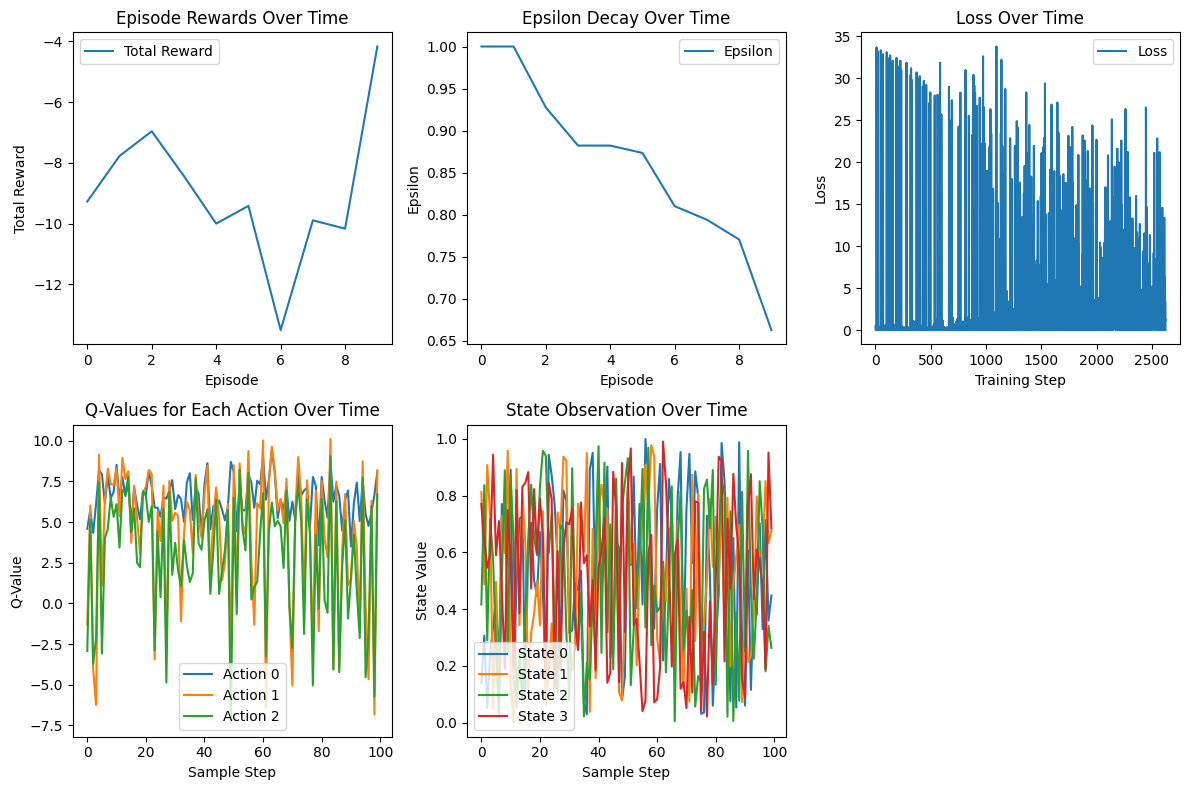

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models
import gym
from gym import spaces

# Environment Definition
class VehicularNetworkEnv(gym.Env):
    def __init__(self):
        super(VehicularNetworkEnv, self).__init__()
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.state = None
        self.reset()

    def reset(self):
        self.state = np.random.rand(4)
        return self.state

    def step(self, action):
        signal_strength, interference, battery, other = self.state
        if action == 0:
            reward = signal_strength - interference - 0.1 * battery
        elif action == 1:
            reward = signal_strength * 1.5 - interference - 0.2 * battery
        elif action == 2:
            reward = signal_strength * 2 - interference - 0.3 * battery
        battery -= action * 0.1
        self.state = np.clip(np.random.rand(4), 0, 1)
        done = battery <= 0
        return self.state, reward, done, {}

    def render(self, mode='human', close=False):
        pass

# DQN Agent Definition
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.history = {'episode': [], 'reward': [], 'epsilon': [], 'loss': []}

    def _build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
            self.history['loss'].append(history.history['loss'][0])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# Training the DQN Agent and Collecting Data for Plots
if __name__ == "__main__":
    env = VehicularNetworkEnv()
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    episodes = 10
    batch_size = 32

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                agent.history['episode'].append(e)
                agent.history['reward'].append(total_reward)
                agent.history['epsilon'].append(agent.epsilon)
                print(f"episode: {e}/{episodes}, score: {total_reward}, e: {agent.epsilon:.2}")
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

    # Plotting Results
    plt.figure(figsize=(12, 8))

    # Episode Rewards Over Time
    plt.subplot(2, 3, 1)
    plt.plot(agent.history['episode'], agent.history['reward'], label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Rewards Over Time')
    plt.legend()

    # Epsilon Decay Over Time
    plt.subplot(2, 3, 2)
    plt.plot(agent.history['episode'], agent.history['epsilon'], label='Epsilon')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay Over Time')
    plt.legend()

    # Loss Over Time
    plt.subplot(2, 3, 3)
    plt.plot(agent.history['loss'], label='Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()

    # Q-Values for Each Action Over Time (Sample of Q-Values)
    q_values_sample = [agent.model.predict(np.reshape(env.reset(), [1, state_size]))[0] for _ in range(100)]
    q_values_sample = np.array(q_values_sample)
    plt.subplot(2, 3, 4)
    for i in range(action_size):
        plt.plot(q_values_sample[:, i], label=f'Action {i}')
    plt.xlabel('Sample Step')
    plt.ylabel('Q-Value')
    plt.title('Q-Values for Each Action Over Time')
    plt.legend()

    # State Observation Over Time (Random Samples)
    states = [env.reset() for _ in range(100)]
    states = np.array(states)
    plt.subplot(2, 3, 5)
    for i in range(state_size):
        plt.plot(states[:, i], label=f'State {i}')
    plt.xlabel('Sample Step')
    plt.ylabel('State Value')
    plt.title('State Observation Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()
